<a href="https://colab.research.google.com/github/nabigwaku/AB-Testing-Using-Python/blob/master/A_B_Testing_Using_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

A/B Testing is a randomized controlled experiment where two versions (A and B) of a system are tested against each other to understand which one performs better. The goal is to compare different variants and assess their impact on key metrics. Its crucial for optimizing website features, marketing strategies, and product enhancements in product management. Used by businesses to improve user experience, increase conversion rates, and boost Return On Investement. By testing small changes, businesses can ensure that every decision is backed by data, reducing the risk of negative impacts.

# How it works

## A/B Testing Process

**Step 1: Define the Hypothesis** e.g: Changing the color of the 'Sign Up' button from blue to green will increase the conversion rate.

**Step 2: Divide the Users into Groups:** Randomly assign users to either the control (A) or test (B) group. The control group experiences the original version, while the test group interacts with the modified version.

**Step 3: Measure Metrics**:e.g Conversion rate, click-through rate, user engagement, etc. Collect the data needed to compare the performance of both versions.

**Step 4: Analyze the Results**: Perform a statistical test (e.g t-test, Z-test) to determine if the differences between the two groups are statistically significant.

## Statistical Significance in A/B Testing
Note:: This tells us if the results of an A/B test are likely due to the change you made, or if they happened by chance.

* Null Hypothesis (H0): There is no difference between the control and test groups.
* Alternative Hypothesis (H1): There is a significant difference between the two groups.
* We use statistical tests (like t-tests) to test these hypotheses and if the p-value is less than 0.05, we reject the null hypothesis and conclude that the new variant has a statistically significant impact.

# Applications:
* **Website Optimization:** Testing changes to design, content, or layout to improve user experience. Metrics to monitor:: Conversion rate, bounce rate, time on site, click-through rate (CTR)
* **Email Marketing**: Testing subject lines, content, or CTA buttons to boost open or click-through, unsubscribe rate
* **Advertising**: Comparing ad creatives, targeting strategies, or bid amounts to maximize return on investment. Metrics to Monitor: Click-through rate (CTR), cost per acquisition (CPA), return on investment (ROI), conversion rate.
* **Product Features**: Testing new features or changes to user interfaces to gauge user engagement, customer satisfaction, user retention and feature adoption rate
* **Machine learning**: Can be used to evaluate model performance by comparing different algorithms, hyperparameters, or feature engineering methods. It helps identify which model or configuration produces the best results, like higher accuracy or lower error.

# Conducting A/B Test Analysis:
##  Conversion Comparison Between Old and New Pages

This A/B test analyzes user interactions on two web pages to evaluate the impact of a new page design. The Null Hypothesis (H₀) assumes no difference in conversion rates between users who see the old page (control group) and those who see the new page (treatment or test group). The Alternative Hypothesis (H₁) assumes a difference in conversion rates, suggesting that the new design may influence conversions.

**Data Status**: At this stage, Control and treatment groups have been assigned, hypotheses are set, and data collection is complete. Users have interacted with their respective pages, and conversions (yes or no) have been recorded. Now, we focus on analyzing this data to determine if the new page significantly affects conversion rates compared to the old page.

**Data Columns**:

* **user_id**: Unique ID for each user.
* **timestamp**: Visit time.
* **group**: Control or treatment group.
* **landing_page**: Page visited (old or new).
* **converted**: Conversion status (1 = converted, 0 = not converted).


## Importing Libraries

In [ ]:
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations
import matplotlib.pyplot as plt  # Visualization
import seaborn as sns  # Statistical visualizations
import scipy.stats as stats  # Statistical functions for hypothesis testing
import statsmodels.stats.api as sms  # Statistical modeling
from statsmodels.stats.proportion import proportions_ztest  # Z-test for proportions
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings("ignore")



## Reading, Cleaning &  Exploring the data

### Reading Data

In [ ]:
data = pd.read_csv('/content/ab_data.csv')
data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


### Exploring the data

In [ ]:
ab_test_shape =  data.shape  # Number of rows and columns
ab_test_unique = data.nunique()  # Unique values in each column
ab_test_missing_values = data.isna().sum()  # Checking for missing values
ab_test_info = data.info()  # Summary of the data frame

print("Shape of the data:", ab_test_shape)
print("\nUnique values in each column:")
print(ab_test_unique)
print("\nMissing values in each column:")
print(ab_test_missing_values)
print("\nSummary of the data frame:")
print(ab_test_info)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB
Shape of the data: (294478, 5)

Unique values in each column:
user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

Missing values in each column:
user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

Summary of the data frame:
None


* There is an issue with duplicate user_id entries, thus this shall need cleaning

In [ ]:
ab_test_group_control = pd.crosstab(data['group'], data['landing_page'])  # Cross-tabulation of 'group' and 'landing_page'
print("Cross-tabulation of 'group' and 'landing_page':")
print(ab_test_group_control)

Cross-tabulation of 'group' and 'landing_page':
landing_page  new_page  old_page
group                           
control           1928    145274
treatment       145311      1965


* There is an issue, group and landing_page data misalignment where users from the control group see the new page or the treatment group sees the old page.

### Data Cleaninig

* Identfied Issues:
  * `Group` and `Landing_Page` data Misalignment. i.en users from the control group see the new page or the treatment group sees the old page. These rows need to be dropped.
  * Duplicate `user_id` entries, the shall need to be dropped to ensure each user is only counted once.

**Dealing with data misalignment**

In [ ]:
ab_test_data = data.copy()  # Create a copy of the original data

ab_test_data = ab_test_data.drop(ab_test_data[(ab_test_data['group'] == 'control') & (ab_test_data['landing_page'] == 'new_page')].index)  # Drop rows where 'group' is 'control' and 'landing_page' is 'new_page'
ab_test_data = ab_test_data.drop(ab_test_data[(ab_test_data['group'] == 'treatment') & (ab_test_data['landing_page'] == 'old_page')].index)  # Drop rows where 'group' is 'treatment' and 'landing_page' is 'old_page'

# Test changes
ab_test_group_control = pd.crosstab(ab_test_data['group'], ab_test_data['landing_page'])  # Cross-tabulation of 'group' and 'landing_page'
print("Cross-tabulation of 'group' and 'landing_page':")
print(ab_test_group_control)

Cross-tabulation of 'group' and 'landing_page':
landing_page  new_page  old_page
group                           
control              0    145274
treatment       145311         0


**Dealing with duplicate user_id entries**

In [ ]:
ab_test_data = ab_test_data.drop_duplicates(subset='user_id', keep='first')  # Drop duplicate user_id entries

# Test changes
ab_test_unique = ab_test_data.nunique()  # Unique values in each column
print("\nUnique values in each column:")
print(ab_test_unique)


Unique values in each column:
user_id         290584
timestamp       290584
group                2
landing_page         2
converted            2
dtype: int64


### [Power Analysis](https://www.spotfire.com/glossary/what-is-power-analysis) and Sample Size Calculation

Note: While you can proceed with your A/B testing without conducting power analysis, it is highly recommended to do so for ensuring your **sample size** is adequate to detect meaningful differences between the groups. Power analysis helps to avoid one `failing to detect a true effect` by confirming that your sample size is large enough to yield reliable results. Without it, there’s a risk of invalid conclusions due to insufficient sample size. therefore while its not mandatory, power analysis adds statistical accuracy to the process.

**How it works**

Power analysis is a statistical technique used to determine the minimum sample size needed to confidently test a hypothesis, reducing the risk of errors.

It focuses on four factors:

1. Effect Size: Strength of the expected outcome.
2. Sample Size: Number of observations needed for reliable results.
3. Significance Level: Threshold for statistical confidence (often set at 5%).
4. Statistical Power: Probability of detecting a true effect (typically 80% to minimize errors).

These elements guide the necessary sample size to avoid overspending while ensuring accurate conclusions from A/B tests.

e.g: At a medium-sized online e-commerce business, the product team is testing a new product page design. The current conversion rate is 12%, and they expect a 2% improvement. Power analysis helps determine how many users need to participate in the test to confidently detect this increase and avoid underpowering the experiment.

Based on the example above lets determine the required sample size for our analysis

In [ ]:
expected_effect = sms.proportion_effectsize(0.12, 0.14)  # Calculate the expected 2% if not define you can set one base on historical data
significance_level = 0.05  # Set the significance level
power = 0.8  # Set the desired power level
sample_size = sms.NormalIndPower().solve_power(expected_effect, power=power, alpha=significance_level, ratio=1)  # Calculate the required sample size

# Print
print("Required Sample Size:", round(sample_size), "observations")

Required Sample Size: 4432 observations


### Randomly Selecting Records from Each Group

We randomly select an equal number of records from both control and treatment groups for unbiased testing based on the sample_size (4433) determined from the Power analysis

In [ ]:
# Randomly select 4433 records from each group
control_group = ab_test_data[ab_test_data['group'] == 'control'].sample(n=int(sample_size), random_state=42)  # Select control group records
treatment_group = ab_test_data[ab_test_data['group'] == 'treatment'].sample(n=int(sample_size), random_state=42)  # Select treatment group records

ab_test_sample = pd.concat([control_group, treatment_group], axis=0)  # Concatenate the selected records
ab_test_sample.reset_index(drop=True, inplace=True)  # Reset the index of the combined DataFrame
print(ab_test_sample.head())

# Test changes
ab_test_sample_group_count = ab_test_sample['group'].value_counts()  # Count of records in each group
print("\n Count of records in each group:")
print(ab_test_sample_group_count)



   user_id                   timestamp    group landing_page  converted
0   787685  2017-01-10 09:09:40.751637  control     old_page          0
1   729407  2017-01-13 22:27:34.228088  control     old_page          0
2   738907  2017-01-08 07:36:16.560979  control     old_page          0
3   901281  2017-01-14 15:35:18.212769  control     old_page          0
4   731171  2017-01-20 17:02:53.291693  control     old_page          0

 Count of records in each group:
group
control      4432
treatment    4432
Name: count, dtype: int64


### Conversion Rate Calculation

The conversion rate is calculated as the average conversion (1 = converted, 0 = not) for both groups

In [ ]:
conversion_rates = ab_test_sample.groupby('group')['converted'].mean()  # Calculate the conversion rate for each group
print("Conversion Rates:")
print(conversion_rates)

Conversion Rates:
group
control      0.124323
treatment    0.120487
Name: converted, dtype: float64


**Visualization of Conversion Rates**

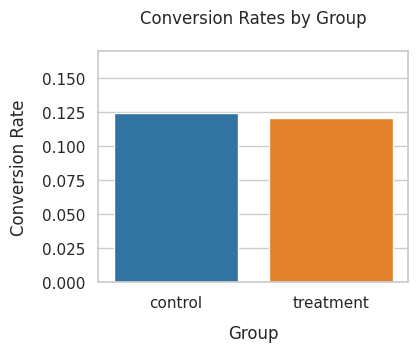

In [ ]:
plt.figure(figsize=(4, 3))  # Set the figure size

# Create a bar plot with custom colors
sns.barplot(
    x=conversion_rates.index,
    y=conversion_rates.values,
    errorbar=('ci', False),
    palette=['#1f77b4', '#ff7f0e'],  # Define colors for each bar
    legend=False  # Turn off the legend
)

# Set the labels and title
plt.ylim(0, 0.17)  # Set the y-axis limits
plt.ylabel('Conversion Rate', labelpad=10)  # Set the y-axis label
plt.title('Conversion Rates by Group', pad=20)  # Set the title
plt.xlabel('Group', labelpad=10)  # Set the x-axis label

plt.show()

### Analyze Test Results

#### Z-Test for Hypothesis Testing

The Z-test is used to check if the difference in conversion rates between groups is statistically significant. The confidence intervals are also calculated for each group

Note:
* **Z-statistic** tells you how far the sample mean is from the population mean.
* **P-value** helps you decide if the difference is significant. If it is lower than 0.05, you reject the null hypothesis (i.e there’s a significant difference).
* **Confidence Intervals** show the range in which the true conversion rate for each group is likely to fall.

In [ ]:
control_results = ab_test_sample[ab_test_sample['group'] == 'control']['converted']  # Extract conversion data for the control group
treatment_results = ab_test_sample[ab_test_sample['group'] == 'treatment']['converted']  # Extract conversion data for the treatment

# calculate the z-statistic and p-values
successes = [control_results.sum(), treatment_results.sum()]  # Number of successes in each group
nobs = [len(control_results), len(treatment_results)]  # Number of observations in each group

print(f'successes: {successes}')
print(f'nobs: {nobs}')

z_stat, p_value = proportions_ztest(successes, nobs)  # Perform the z-test
print("\nZ-statistic:", round(z_stat,2))
print("P-value:", round(p_value,3))

(lower_control, lower_treat), (upper_control, upper_treat) = sms.proportion_confint(successes, nobs=nobs, alpha=0.05)  # Calculate confidence intervals for each group

print("\nConfidence Interval for Control Group:")
print(f"[{lower_control:.3f}, {upper_control:.3f}]")
print("\nConfidence Interval for Treatment Group:")
print(f"[{lower_treat:.3f}, {upper_treat:.3f}]")

successes: [551, 534]
nobs: [4432, 4432]

Z-statistic: 0.55
P-value: 0.582

Confidence Interval for Control Group:
[0.115, 0.134]

Confidence Interval for Treatment Group:
[0.111, 0.130]


### Interpretation of Results

The z-statistic (0.55) and p-value (0.582) suggest that the difference in conversion rates between the old and new pages is likely due to chance, not because one page is truly better. As the z-statistic is close to zero implying that the observed difference between groups is not significant and the p-value of 0.582 suggests there's no significant difference in conversion rates between the groups.

The confidence intervals that show the estimated range for each page’s conversion rate i.e
 * Old page: 11.5% to 13.4%
 * New page: 11.1% to 13.0%

Since these ranges overlap, it’s likely that both pages perform about the same, meaning the new design does not lead to more conversions than the old one.



### Conclusion

Thus since the p_value is greater than 0.05, we fail to reject the null hypothesis implying there is no difference in conversion rates between users who see the old page (control group) and those who see the new page (treatment or test group)

### Recommendation

Based on the results, it seems that there is no significant difference between the old and new page in terms of conversions. This means that the new page did not perform any better than the old one. Thus, the recommendation would be to keep using the old page for now and if you still want to improve conversions, you may need to try other changes or designs and test again later.
